## Biases from source confusion with realistic mass distribution

In [1]:
# Import packages that you may already have pip installed in your environment.

import sys
import scipy

import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
from scipy import signal
import os
import warnings
import pickle

# Import other packages which are less common and specific to the task at hand.

#from functions import *
import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches

In this code, we deal with populations of signals lurking in the data and tempering the PE of a fitted signal. The population is drawn from a mock catalog, whose size is to be specified just below here

In [2]:
# Large number: size of mock catalog of sources to draw from
N_mock = 1000

### Generate reference signals in the time and frequency domains

A few useful units

In [3]:
# Bunch of units

GM_sun = 1.3271244*1e20
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = 10**6 * pc

Inner product in the fourier domain

In [4]:
def inner_prod_FD(sig1_f,sig2_f,PSD,delta_f):
    """
    Only makes sense for continuous fourier transforms. (No dt's floating around). 
    This takes as input dimensionful quantities.
    
    This is the continous Fourier transform inner product.
    """
    return (4*delta_f) * np.real(np.sum(np.conjugate(sig1_f)*sig2_f/PSD))

Here we define the TaylorF2 approximant up to 3.5PN contributions.
References for TaylorF2 model

- https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)]
- https://arxiv.org/pdf/0907.0700.pdf [Eqs.(3.17)-(3.18)]

In [5]:
def htilde(f,Deff,params,tune,t0, phi0):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Important:
    
    This model is defined in the frequency domain directly and it necessitates
    continuous fourier transforms in the inner products (no discretizations!)
    
    Note on distance: 
    
    Notice that the effective distance contains information about the angular dependence
    of the binary. The model can thus be used for all detectors, as long as this distance
    parameter is chosen consistently. 
    
    Note on spin: 
    
    The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
    Notice that this quantity is constructed in such a way to be smaller or equal
    than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
    The coefficient enters the phase as in Eq.(2.2) in the same paper.
    """
    # Units
    
    GM_sun = 1.3271244*1e20
    c =2.9979246*1e8
    M_sun =1.9884099*1e30
    G = 6.6743*1e-11
    pc= 3.0856776*1e16
    pi = np.pi
    Mpc = 10**6 * pc
    
    # Load the parameters
    Mchirp_true = np.exp(params[0])
    eta_true = params[1]
    beta_true = params[2]
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    
    # PN expansion parameter (velocity).
    v = (pi*G*Mchirp_true*eta_true**(-3/5)/(c**3) * f)**(1/3)
    
    # Amplitude explicitly given in terms of units and frequency.
    # Notice that lowest PN order here is fine. Biggest contributions from phase.
    amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp_true/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    
    # Phase: add or remove PN orders here as you see fit.
    psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
    psi1PN = (3715/756+55/9*eta_true)*v**(-3)
    psi1_5PN_tails = -16*pi*v**(-2)
    psi1_5PN_spin = 4*beta_true*v**(-2)
    psi2PN = (15293365/508032+27145/504*eta_true+3085/72*eta_true**2)*v**(-1)
    psi25PNlog = pi*(38645/252- 65/3 *eta_true)* np.log(v)
    psi3PN = v*(11583231236531/4694215680 -640/3 * pi**2 -6848/21 *np.euler_gamma
              + eta_true*(-15335597827/3048192+2255/12 * pi**2-1760/3 * theta - 12320/9 * delta)
              + eta_true**2 *76055/1728 - eta_true**3 * 127825/1296 - 6848/21 * np.log(4))
    psi3PNlog = - 6848/21 *v * np.log(v)
    psi35PN = pi * v**2 * (77096675./254016 + 378515./1512 *eta_true - 74045./756 * eta_true**2* tune)

    psi_fullPN = 3/(128*eta_true)*(v**(-5)+psi1PN+psi1_5PN_tails+psi1_5PN_spin+psi2PN
                                  + psi25PNlog + psi3PN + psi3PNlog + psi35PN)
    psi = psi_const + psi_fullPN 
    
    return amplitude* np.exp(-1j*psi)

def T_chirp(fmin,M_chirp,eta):
    
    M = M_chirp*eta**(-3/5)
    v_low = (pi*G*M_chirp*eta**(-3/5)/(c**3) * fmin)**(1/3)
    
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    gamma = np.euler_gamma
    
    pre_fact = ((5/(256*eta)) * G*M/(c**3))
    first_term = (v_low**(-8) + (743/252 + (11/3) * eta ) * (v_low **(-6)) - (32*np.pi/5)*v_low**(-5)
                +(3058673/508032 + (5429/504)*eta + (617/72)*eta**2)*v_low**(-4)
                 +(13*eta/3 - 7729/252)*np.pi*v_low**-3)
    
    second_term = (6848*gamma/105 - 10052469856691/23471078400 + 128*pi**2/3 + (
    3147553127/3048192 - 451*(pi**2)/12)*eta - (15211*eta**2)/1728 + (2555*eta**3 / 1296) +
                   (6848/105)*np.log(4*v_low))*v_low**-2
    
    third_term = ((14809/378)*eta**2 - (75703/756) * eta - 15419335/127008)*pi*v_low**-1
    return pre_fact * (first_term + second_term + third_term)

The function below is used to truncate the waveforms drawn from the population which go beyond the frequency at chirp of the signal we are inferring from. 

This is mainly because of Python shaenanigans, it doesn't matter much as far as the Physics is concerned.

In [6]:
def pad_or_truncate(l, n, pad=0):
    
    
    """
    If the length of an array is higher than a specified value, this cuts the
    length of said array down to the specified value.
    """
    if len(l) >= n:
        return l[:n]
    
    """
    If the length is smaller, it adds zeros like there's no tomorrow to reach
    the length given by the specified value
    """
    lis = l.tolist()
    while len(lis)<n:
        lis.append(pad)
    
    res = np.asarray(lis)
    return res

Input some true parameters for the true signal and for the unresolved binaries. We choose these to resemble a gravitational wave passing by.

In [7]:
"""
Signal parameters
"""

# Fix these two impostors, assume they are known perfectly.
phiref =0.

# Find a resonable distance for GBs

Deff = 10**3 *Mpc
logDeff = np.log(Deff)

# variables to sample through

beta_true = 5.0
eta_true = 0.21
mtot = 2*1e6 #in solar masses
Mchirp = mtot*(eta_true)**(3/5)
Mchirp_true =Mchirp* M_sun
logMchirp_true = np.log(Mchirp_true)

pars = [logMchirp_true,eta_true,beta_true] # array of parameters to sample through

Here we set up the signal in the time and frequency domain, as described in the appendix to the paper.

In [8]:
"""
Time array.
"""
fmin =  0.00025
fmax =  c**3/(6*np.sqrt(6)*pi*G*Mchirp_true *eta_true**(-3/5))#0.0002
t_year = 365*24*60*60       


T_obs = T_chirp(fmin,Mchirp_true,eta_true)  # Take signal in seconds.
# Coalescence time of ref source
# is the observation time.
tref = T_obs
delta_t = 1/(2*fmax)                        # Sampling interval in seconds (Shannon's th.)
t = np.arange(0,T_obs,delta_t)              # set up time array
N_t = int(2**(np.ceil(np.log2(len(t)))))    # In the inner products in the time domain, 
                                            # N_t should be length of padded signal,
                                            # e.g., a power of 2.


delta_f =  1/T_obs
freq = np.arange(fmin,fmax,delta_f)

print('N_t:',N_t)
print('df:', delta_f)
print('We observe for',T_obs,'s, ',12*30*T_obs/t_year,'days, ',T_obs/t_year,'yr')
print('fmin:', fmin)
print('fmax:', fmax)
print('The binary chirps at f =',c**3/(6*np.sqrt(6)*pi*G*Mchirp_true *eta_true**(-3/5) ))
print('Length of frequency array:', len(freq))

N_t: 2048
df: 2.6111011965469084e-06
We observe for 382980.17760570353 s,  4.371919835681547 days,  0.012144221765782075 yr
fmin: 0.00025
fmax: 0.0021985873919213874
The binary chirps at f = 0.0021985873919213874
Length of frequency array: 747


### Generate noise

Next, we build up noise. We use Parseval's theorem to calculate the noise. This amounts to using the following variance

$$
\sigma^2_n= \frac{S_n}{4 dt} N_t
$$

where:

- $\sigma^2$ is the noise variance.
- $S_n$ is the detector's PSD.
- $dt$ is the sampling interval.
- $N_t$ is the length of the (padded) signal.

In [9]:
def PowerSpectralDensity(f):
    """
    Power Spectral Density for the LISA detector assuming it has been active for a year. 
    I found an analytic version in one of Niel Cornish's paper which he submitted to the arXiv in
    2018. I evaluate the PSD at the frequency bins found in the signal FFT.
    
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf.
    Values chosen for confusion noise after 1 year of observation.
    [16/12/2020]: removed confusion noise after 1 year of observation. Avoid confusion
                  between different timescales of the problem.
    
    """
    
    sky_averaging_constant = 1.0 # set to one for one source
    #(20/3) # Sky Averaged <--- I got this from Jonathan's notes
    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**(-3)    

    Poms = ((1.5e-11)*(1.5e-11))*(1 + np.power((2e-3)/f, 4))  # Optical Metrology Sensor
    Pacc = (3e-15)*(3e-15)* (1 + (4e-4/f)*(4e-4/f))*(1 + np.power(f/(8e-3),4 ))  # Acceleration Noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    Sc = 9e-45 * np.power(f,-7/3)*np.exp(-np.power(f,alpha) + beta*f*np.sin(k*f)) * (1 + np.tanh(gamma*(f_k- f)))  

    PSD = (sky_averaging_constant)* ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD

    return PSD

In [10]:
np.random.seed(1245)
PSD = PowerSpectralDensity(freq)

noisevar = PSD/(4*delta_f) # Noise variance defined for continuous FTs.
noisemean = 0. 


n_f = []

for i in range(0,N_mock):
    noise_real = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute real noise.
    noise_imag = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute imaginary noise.

    n_f.append(np.array(noise_real + 1j*noise_imag))         # noise array in the frequency domain.

### Fisher results

This part is concerned with the Fisher-matrix exploration of biases from the confusion noise of a population of BHs. 

----

First we build the Fisher matrix of the signal we want to infer from. As this is the only signal we assume is in the data, the Fisher matrix ought to contain only derivatives with respect to its 3 parameters.

In [11]:
# Derivative wrt Mc.

lnMc_delta = 1e-4
pars_p = [pars[0] + lnMc_delta,pars[1],pars[2]]
pars_m = [pars[0] - lnMc_delta,pars[1],pars[2]]
d_dlnMc = (htilde(freq,Deff,pars_p,1,tref,phiref)-htilde(freq,Deff,pars_m,1,tref,phiref))/(2*lnMc_delta)

# Derivative wrt eta.
eta_delta = 1e-6
pars_p = [pars[0],pars[1] + eta_delta,pars[2]]
pars_m = [pars[0],pars[1] - eta_delta,pars[2]]
d_deta = (htilde(freq,Deff,pars_p,1,tref,phiref)-htilde(freq,Deff,pars_m,1,tref,phiref))/(2*eta_delta)

# Derivative wrt beta

beta_delta = 1e-6
pars_p = [pars[0],pars[1],pars[2]+ beta_delta]
pars_m = [pars[0],pars[1],pars[2]- beta_delta]
d_dbeta = (htilde(freq,Deff,pars_p,1,tref,phiref)-htilde(freq,Deff,pars_m,1,tref,phiref))/(2*beta_delta)

"""
Find the Fisher matrix with your approximate waveforms, as this is the
one which is input in the MCMC and is thus the known waveform.
"""
tune_app = 1

diff_vec =[d_dlnMc,d_deta,d_dbeta]

fish_mix = np.eye(3)
for i in range(0,3):
    for j in range(0,3):
        fish_mix[i,j] = inner_prod_FD(diff_vec[i],diff_vec[j],PSD,delta_f)
        
# Inverse of the FM

FM_inv = np.linalg.inv(fish_mix)

In [12]:
# errors on lnMc, eta, beta.
print('FM width predictions:',np.sqrt(np.diag(np.linalg.inv(fish_mix))))

FM width predictions: [4.04889582e-06 1.90917463e-05 8.96193457e-04]


----

Here we construct the *confusion noise* term $\Delta H_\text{conf}$ (using the terminology of the paper). We build it from sources drawn from a similar population. We decide to let the BHs share the mass (parent) distribution only, as described below.

Starting from the probability density $p(M|\lambda)=\mathcal{N} M^{\alpha_0-1}$, we can use the method of inversion to get the source parameter M. In particular, we define the cumulative density function,

$u:=\text{CDF}(M)= \mathcal{N}\int_{M_\text{min}}^{M}M^{\alpha_0-1}dM = \alpha_0^{-1}\mathcal{N}M^{\alpha_0}\big|_{M_\text{min}}^{M}=\alpha_0^{-1}\mathcal{N}(M^{\alpha_0}-M^{\alpha_0}_{\text{min}})$.

The normalization factor can be calculated imposing that $\lim_{M\rightarrow M_{\text{min}}} u=1$, which gives immediately:

$\mathcal{N}=\frac{\alpha_0}{M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}}}$.

Now, we get M in terms of $u$, 

$\quad M^{\alpha_0}=\alpha_0\mathcal{N}^{-1} u +M^{\alpha_0}_{\text{min}}\quad\Longrightarrow \quad \ln M =\frac{1}{\alpha_0} \ln\big[(M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}})\, u +M^{\alpha_0}_{\text{min}}\big]\quad $ (true parameter distribution).

We set up the stage by calculating the list of mock chirp and total masses for each element of the mock catalog.

In [13]:
np.random.seed(355678)

# Inputs to get the true ln M distribution
alpha0_t = 0.003 # Greene Ho fit from Gair, Tang, Volonteri (2010)
M_min=10**4* M_sun ;   logM_min = np.log(M_min)
M_max=10**7* M_sun; logM_max = np.log(M_max)

for i in range(0,N_mock):
    
    lnD_mock = np.random.uniform(np.log(1*10**3*Mpc),np.log(5*10**3*Mpc),N_mock)
    beta_mock = np.random.uniform(0.001,9.4,N_mock)
    eta_mock = np.random.uniform(0.001,0.05,N_mock)
    
    """
    No noise added: these will not be "observed", and they define the true
    parameters of signals that go completely missed.
    """
    logM_mock=alpha0_t**-1 *np.log((M_max**(alpha0_t)-M_min**(alpha0_t))*np.random.uniform(size=N_mock)+
               M_min**(alpha0_t)*np.ones(N_mock))
    
    # Find the log of the chirp mass (needed for h_tilde) from the distribution
    # of the total mass.
    M_mock = np.exp(logM_mock)
    logMc_mock = np.log(M_mock*eta_mock**(3/5))

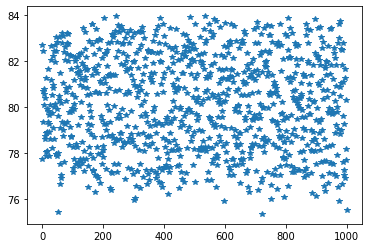

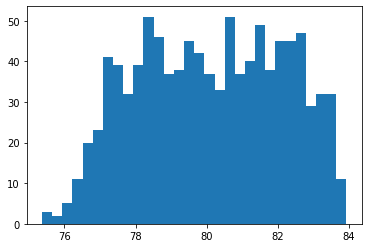

In [14]:
# Scatter plot of masses
plt.plot(logMc_mock,'*')
plt.show()

# Mass distribution
plt.hist(logMc_mock, 30)
plt.show()

From the mass distribution above, and uniform distributions for the frequency, phase and time of coalescence (see below), we calculate the SNR for each source in the mock catalog. If the SNR is below 15, then we consider the source missed and add it to h_missed. From this list, we later construct $\Delta H_\text{conf}$.

In [15]:
SNR_missed =[]
h_missed = []
pars_missed = []

for i in range(0,len(lnD_mock)):
    
    
    # Mock distributions of frequency, 
    fmax_mock =  c**3/(6*np.sqrt(6)*pi*G*np.exp(logMc_mock[i]) *eta_mock[i]**(-3/5))
    # time of coalescence,
    T_obs_mock = T_chirp(fmin,np.exp(logMc_mock[i]),eta_mock[i])
    # and phase at coalescence.
    phi_mock = np.random.uniform(0,2*pi)
    
    # Build up a frequency array for each source in the mock catalog.
    delta_f_mock =  1/(T_obs_mock)
    freq_mock = np.arange(fmin,fmax_mock, 1e3*delta_f_mock)
    
    if len(freq_mock)>len(freq):
        
        # If the frequency goes beyond the chirp frequency of the reference signal,
        # then brutally cut the frequency of the source.
        freq_mock = freq_mock[:len(freq)]
        
        # Find the SNR of the source
        h = htilde(freq_mock,np.exp(lnD_mock[i]),
                 [logMc_mock[i],eta_mock[i],beta_mock[i]],1,
                  T_obs_mock,phi_mock)
        rho = np.sqrt(inner_prod_FD(h,h,PSD,delta_f))
    
    else:
        
        # if the mock source does not reach the frequency of chirp of the ref. signal,
        # then we must cut the PSD to avoid different lengths, which Python abhors.
        PSD_new = PSD[:len(freq_mock)]
        
        # Doing that we can calculate the SNR.
        h = htilde(freq_mock,np.exp(lnD_mock[i]),
                 [logMc_mock[i],eta_mock[i],beta_mock[i]],1,
                   T_obs_mock,phi_mock)
        rho = np.sqrt(inner_prod_FD(h,h,PSD_new,delta_f))
        
    # Add a bit of spice to the SNR by multiplying by noise.
    rho_obs = rho+np.random.normal(0,1)
    
    # Compare the SNR obtained with the threshold one.
    if rho_obs<15:
        SNR_missed.append(rho_obs)
        h_missed.append(h)
        pars_missed.append([logMc_mock[i],eta_mock[i],beta_mock[i]])
        
print('We have',len(SNR_missed),'unfitted sources')

We have 199 unfitted sources


In [16]:
# This was the Python shaenanigan mentioned before.
# Bottomline: we need the padded signals to have the same length. We force them to.

h_missed_pad = []
for i in h_missed:
    
    if len(i)<len(freq):
        
        h_missed_pad.append(pad_or_truncate(i,len(freq)))
    else:
        h_missed_pad.append(i)

Here we consider biases from confusion noise

In [17]:
# The sum of the missed signals is the confusion noise.
deltaH=sum(h_missed_pad)

lnMc_cumulative_bias = []
eta_cumulative_bias  = []
beta_cumulative_bias = []
H_conf_list = []

"""
The loop below creates lists that allow us to calculate biases retaining only
up to the i^th source in the catalog. This is needed if we want to calculate
how the bias increses as a number of sources we throw into deltaH.
"""

for i in range(0,len(h_missed)):
    
    # Calculate deltaH up to the chosen number of sources.
    deltaH_cumulative = sum(h_missed_pad[0:i])
    H_conf_list.append(deltaH_cumulative)
    
    """
    Optional:Print the (cumulative, hopefully) increase in the SNR.
    """
    #print('SNR up to source #',i+1,':',round(np.sqrt(
    #    inner_prod_FD(deltaH_cumulative,deltaH_cumulative,PSD,delta_f)),1))
    
    # Bias vectors from FM calculated offline and DeltaH up to i.
    deriv_inn_prod_lnMc_cumulative = inner_prod_FD(d_dlnMc,deltaH_cumulative,PSD,delta_f)
    deriv_inn_prod_eta_cumulative  = inner_prod_FD(d_deta,deltaH_cumulative,PSD,delta_f)
    deriv_inn_prod_beta_cumulative = inner_prod_FD(d_dbeta,deltaH_cumulative,PSD,delta_f)
    
    b_cumulative = [deriv_inn_prod_lnMc_cumulative,deriv_inn_prod_eta_cumulative,
                    deriv_inn_prod_beta_cumulative]
    
    # Find the associated biases up to the ith source.
    biases_pred_cumulative = np.matmul(FM_inv,b_cumulative)
    
    # Append the biases on lists which we can plot later on.
    lnMc_cumulative_bias.append(biases_pred_cumulative[0])
    eta_cumulative_bias.append(biases_pred_cumulative[1])
    beta_cumulative_bias.append(biases_pred_cumulative[2])


In [18]:
# Find index of largest bias

"""
These lines of code give us the index (number of the ith configuration) 
for which biases are the largest. The index is the one for which any of the 
biases from lnMc, eta, beta is the largest.
"""

R_lnMc = abs(lnMc_cumulative_bias/np.sqrt(FM_inv[0][0]))
R_eta = abs(eta_cumulative_bias/np.sqrt(FM_inv[1][1]))
R_beta = abs(beta_cumulative_bias/np.sqrt(FM_inv[2][2]))
bias_list = [max(R_eta),max(R_lnMc),max(R_beta)]

R_list=[R_lnMc,R_eta,R_beta]
R_max_list = [max(R_lnMc),max(R_eta),max(R_beta)]

list_max_index = np.where(R_max_list == max(R_max_list))[0][0]
index = np.where(R_list[list_max_index]==R_max_list[list_max_index])[0][0]

Here we consider biases from detector noise. We play the same game as before. 
For each element of the cumulative $\Delta H_\text{conf}$, we draw a random realization of the noise. 

A key difference is that here we do not cumulate the detector noise.

In [19]:
lnMc_noise = []
eta_noise  = []
beta_noise = []

for i in range(0,len(h_missed)):
    
    
    # Bias vectors from FM calculated offline and DeltaH up to i.
    deriv_inn_prod_lnMc_noise = inner_prod_FD(d_dlnMc,n_f[i],PSD,delta_f)
    deriv_inn_prod_eta_noise  = inner_prod_FD(d_deta,n_f[i],PSD,delta_f)
    deriv_inn_prod_beta_noise = inner_prod_FD(d_dbeta,n_f[i],PSD,delta_f)
    
    b_noise = [deriv_inn_prod_lnMc_noise,deriv_inn_prod_eta_noise,
                    deriv_inn_prod_beta_noise]
    
    # Find the associated biases
    biases_pred_noise = np.matmul(FM_inv,b_noise)
    
    # Append the biases on lists.
    lnMc_noise.append(biases_pred_noise[0])
    eta_noise.append(biases_pred_noise[1])
    beta_noise.append(biases_pred_noise[2])


# Bias ratios
R_lnMc_noise = abs(lnMc_noise/np.sqrt(FM_inv[0][0]))
R_eta_noise = abs(eta_noise/np.sqrt(FM_inv[1][1]))
R_beta_noise = abs(beta_noise/np.sqrt(FM_inv[2][2]))

Plot the findings, both for confusion and detector noise. 

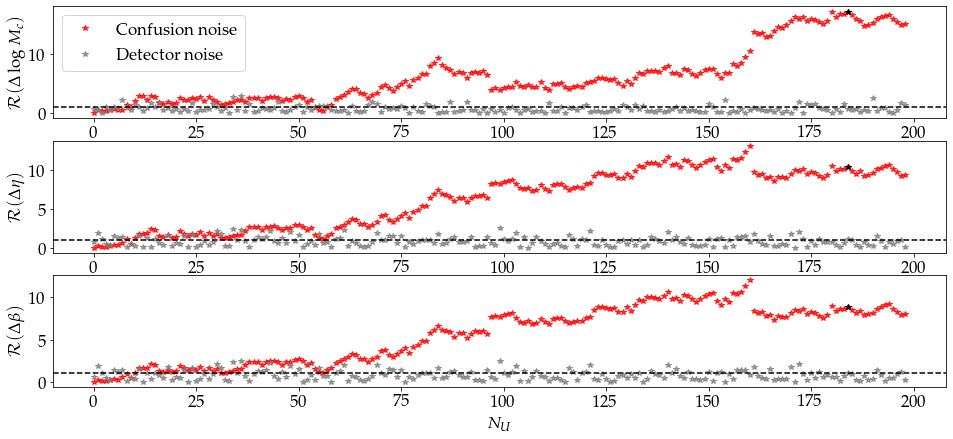

In [20]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size":17
})

# Set up subplots
fig,ax = plt.subplots(3,figsize = (16,7))

ax[0].plot(R_lnMc,'*',color='red',alpha = 0.8,label='Confusion noise')
ax[0].plot(R_lnMc_noise,'*',color='gray',alpha = 0.8,label='Detector noise')
ax[0].plot(index,abs(lnMc_cumulative_bias[index]/np.sqrt(FM_inv[0][0])),'*',color='black')
ax[0].axhline(y=1, color='black', linestyle='--')
ax[0].set_ylabel(r'$\mathcal{R}(\Delta\log M_c)$')
ax[0].legend(loc="upper left")

ax[1].plot(R_eta,'*',color='red',alpha = 0.8)
ax[1].plot(R_eta_noise,'*',color='gray',alpha = 0.8)
ax[1].plot(index,abs(eta_cumulative_bias[index]/np.sqrt(FM_inv[1][1])),'*',color='black')
ax[1].axhline(y=1, color='black', linestyle='--')
ax[1].set_ylabel(r'$\mathcal{R}(\Delta\eta)$')

ax[2].plot(R_beta,'*',color='red',alpha = 0.8)
ax[2].plot(R_beta_noise,'*',color='gray',alpha = 0.8)
ax[2].plot(index,abs(beta_cumulative_bias[index]/np.sqrt(FM_inv[2][2])),'*',color='black')
ax[2].axhline(y=1, color='black', linestyle='--')
ax[2].set_ylabel(r'$\mathcal{R}(\Delta\beta)$')

plt.xlabel(r'$N_U$')
#plt.savefig('noise_det_conf.pdf')
plt.show()

For the MCMC check, we pick the instance of $\Delta H_\text{conf}$ that gives the biggest overall beta. We have found the index for that above.

In [21]:
H_conf = H_conf_list[index]
n_f_max = n_f[index]

### Build the data array

Finally, set up the data in the frequency domain. We add the noise realization drawn for the ith configuration of $\Delta H_\text{conf}$ with largest bias, the confusion noise and the reference signal.

We do not include waveform errors in the signal, so we expect no biases from it.

In [22]:
# resolved signals:

h_true_vec_f = htilde(freq,Deff,pars,1,tref,phiref)

# data array

data_f_vec = h_true_vec_f + H_conf + n_f_max

And finally we calculate the SNRs, to check that both resolved and sum of the unresolved signals are high enough.

In [23]:
# SNR of the resolved source

SNR2 = inner_prod_FD(data_f_vec,h_true_vec_f,PSD,delta_f) 
h_SNR2 = inner_prod_FD(h_true_vec_f,h_true_vec_f,PSD,delta_f)  #CTFT

rho = np.sqrt(SNR2)
print('Optimal SNR for the resolved source is',rho)
print('SNR of confusion noise:',np.sqrt(inner_prod_FD(H_conf,H_conf,PSD,delta_f)))

Optimal SNR for the resolved source is 4192.460684266009
SNR of confusion noise: 191.74735880676045


### MCMC checks

Here we setup the MCMC check. First of all we write down the priors.

In [24]:
# Priors on frequency
eta_low_range = 0.01  
eta_high_range = 0.25

# Priors on the phase
logMchirp_low_range = np.log(10*M_sun)
logMchirp_high_range = np.log(20000000*M_sun)

# Priors on spin parameters: check Berti, Buonanno, Will.
beta_low = 0.1
beta_high = 9.4

In [25]:
def lprior_eta(eta):


    if eta < eta_low_range or eta > eta_high_range: # are you out of your range?
        print('I am out of my range. Problem is eta.')
        return -1e10 
    else:
        return np.log(1/(eta_high_range - eta_low_range))

def lprior_logMchirp(logMchirp):
    
    if logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range: # are you out of your range?
        print('I am out of my range. Problem is Mchirp.')
        return -1e10
    else:
        return np.log(1/(logMchirp_high_range - logMchirp_low_range))

def lprior_beta(beta):

    
    if beta < beta_low or beta > beta_high: # are you out of your range?
        print('I am out of my range. Problem is beta.')
        return -1e10
    else:
        return np.log(1/(beta_high - beta_low))

Next we calculate the (log-)likelihood.
$$
p(d|\theta)\sim \exp\left\{\frac{1}{2}\left(d-h|d-h\right)\right\}
$$
and the log posterior.

In [26]:
"""
These functions were originally coded up by Ollie Burke.
They must be changed based on the parameters to sample through and their priors.
"""

def llike(params, data_f):
    """
    Assumption: Known PSD otherwise need additional term.
    Search the posterior with your approximate waveform.
    """
    signal_f = htilde(freq,Deff,params,1,tref,phiref)
    return(-0.5 * np.sum((np.abs(data_f - signal_f)**2) / noisevar))

def lpost(params):
    '''
    Compute log posterior.
    '''
    data_f = data_f_vec
    logMchirp = params[0]
    eta = params[1]
    beta = params[2]
    
    if beta < beta_low or beta > beta_high or eta < eta_low_range or eta > eta_high_range or logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range:
        res = -np.inf
    else:
        res = llike(params, data_f) + lprior_logMchirp(params[0]) + lprior_eta(params[1])+lprior_beta(params[2])

    return res

Here we define and run the sampler. Notice we only consider the parameters of the reference signal.

In [27]:
iterations = 10000


pos = [logMchirp_true,eta_true,beta_true]


"""
Notice that here we start around the true values. In this sense we are
not perfoming a search, but merely checking Fisher estimates. Change the prefactor 
of the random number if you want to explore a bit more of the parameter space.
"""

start= pos*(1+5e-14* np.random.randn(6, 3))

# output
nwalkers, ndim = start.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)
sampler.run_mcmc(start, iterations, progress=True)
flat_samples = sampler.get_chain(discard=1500, thin=1, flat=False)

100%|██████████| 10000/10000 [00:24<00:00, 415.84it/s]


In [28]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

org_samp = np.vstack( (flat_samples[:,:,0].flatten() , flat_samples[:,:,1].flatten() , 
                       flat_samples[:,:,2].flatten() ) ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (51000, 3)
median =  [83.33722407  0.21017834  4.99296271]


Here we check that the width of the MCMC posteriors is consistent with the likelihood width prediction from the Fisher matrix of the reference signal.

In [29]:
# errors on lnMc, eta, beta.
print('FM width predictions:',np.sqrt(np.diag(np.linalg.inv(fish_mix))))

"""
Width of posteriors from MCMC. This should be close to the FM
approximation just above.
"""
print('MC width predictions:',  [np.round(np.sqrt(np.var(flat_samples[:,:,0])),17),
                                 np.round(np.sqrt(np.var(flat_samples[:,:,1])),17),
                                 np.round(np.sqrt(np.var(flat_samples[:,:,2])),17)])

FM width predictions: [4.04889582e-06 1.90917463e-05 8.96193457e-04]
MC width predictions: [4.0731680034e-06, 1.914715705278e-05, 0.00089782117656673]


In [30]:
# Nice plotting options for corner plots.

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size":15
})

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = True


CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours. 
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=18), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=16), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=2, # set a limit to ticks in the x-y axes.
    title_fmt=".6f", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

In [31]:
# Pick biases from massive lists above. 
# We expect the bias from the MCMC to be consistent with the one we obtained
# through the Fisher analysis above.

lnMc_bias_sig = lnMc_cumulative_bias[index]
eta_bias_sig = eta_cumulative_bias[index]
beta_bias_sig = beta_cumulative_bias[index]

lnMc_noise_max = lnMc_noise[index]
eta_noise_max = eta_noise[index]
beta_noise_max = beta_noise[index]

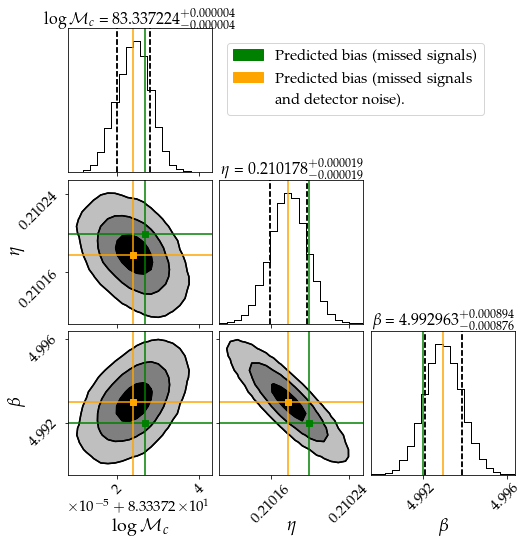

In [32]:
labels = [r'$\log\mathcal{M}_c$', r'$\eta$', r'$\beta$']
truths=[logMchirp_true,eta_true,beta_true]
truths_bias_sig=[logMchirp_true+lnMc_bias_sig,
                   eta_true+eta_bias_sig,
                   beta_true+beta_bias_sig]
truths_w_noise=[logMchirp_true+lnMc_bias_sig + lnMc_noise_max,
                   eta_true+eta_bias_sig + eta_noise_max, 
                   beta_true+beta_bias_sig + beta_noise_max]

fig =corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths_bias_sig,
                    truth_color='green', 
                    color='black',**CORNER_KWARGS)

corner.corner(org_samp, bins=20,labels=labels, 
                truths=truths_w_noise,
                truth_color='orange', 
                color='black',fig = fig,**CORNER_KWARGS)

orange_patch = mpatches.Patch(color='green', label='Predicted bias (missed signals)')
red_patch = mpatches.Patch(color='orange', label='Predicted bias (missed signals')
white_patch = mpatches.Patch(color='white', label='and detector noise).')

plt.legend(handles=[orange_patch,red_patch,white_patch],bbox_to_anchor=(-1., 3.), 
           loc='upper left', borderaxespad=0.)
#plt.savefig('confnoise_bias.pdf')
plt.show()

Even in the most extreme case (based on significance of biases, in this case $\sim 10\sigma$!), the Fisher matrix is still valid. The prediction from the Fisher matrix is remarkably good.